In [ ]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.manifold import TSNE
from keras.layers import concatenate

In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
x_train ,y_train = train
x_test ,y_test =  test

In [ ]:
x_train = np.stack([x_train] * 3, axis=-1)
x_test = np.stack([x_test] * 3, axis=-1)
x_train.shape, x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
x_train = np.array([np.array(Image.fromarray(img).resize((100,100), resample=Image.BILINEAR)) for img in x_train])
x_test = np.array([np.array(Image.fromarray(img).resize((100,100), resample=Image.BILINEAR)) for img in x_test])
x_train.shape, x_test.shape

((60000, 100, 100, 3), (10000, 100, 100, 3))

In [ ]:
inception_v3 = InceptionV3(include_top=False,input_shape=(100,100,3))
for layer in inception_v3.layers:
    layer.trainable = False

In [ ]:
outputs = tf.keras.layers.Dense(10, activation='softmax')(tf.keras.layers.Dense(64, activation='relu')(tf.keras.layers.Dense(256, activation='relu')(tf.keras.layers.Flatten()(inception_v3.output)))
model = tf.keras.models.Model(inputs=inception_v3.input, outputs=predictions)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
y = model.fit(x_train, y_train, epochs=5, batch_size=128,validation_data=(x_test, y_test),steps_per_epoch=200)

Epoch 1/5
200/200 [==============================] - 19s 69ms/step - loss: 9.3685 - accuracy: 0.5704 - val_loss: 4.4138 - val_accuracy: 0.6679
Epoch 2/5
200/200 [==============================] - 12s 58ms/step - loss: 3.5891 - accuracy: 0.6771 - val_loss: 3.2243 - val_accuracy: 0.6877
Epoch 3/5
200/200 [==============================] - 15s 77ms/step - loss: 2.8520 - accuracy: 0.7042 - val_loss: 2.8907 - val_accuracy: 0.6894
Epoch 4/5
200/200 [==============================] - 14s 68ms/step - loss: 2.5187 - accuracy: 0.7136 - val_loss: 2.5758 - val_accuracy: 0.6994
Epoch 5/5
200/200 [==============================] - 11s 57ms/step - loss: 2.1951 - accuracy: 0.7277 - val_loss: 2.3122 - val_accuracy: 0.7124


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Loss:', score[0])
print('Accuracy:', score[1])

Test loss: 2.3121511936187744
Test accuracy: 0.7124000191688538


In [ ]:
img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = tf.keras.layers.Dense(16, activation='linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(4, activation='linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(1, activation='sigmoid')(combined_features)

similarity_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [combined_features], name = 'Siamese_model')
similarity_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
similarity_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 16)           336         ['merge_features[1][0

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_test)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig

1/1 [==============================] - 0s 100ms/step


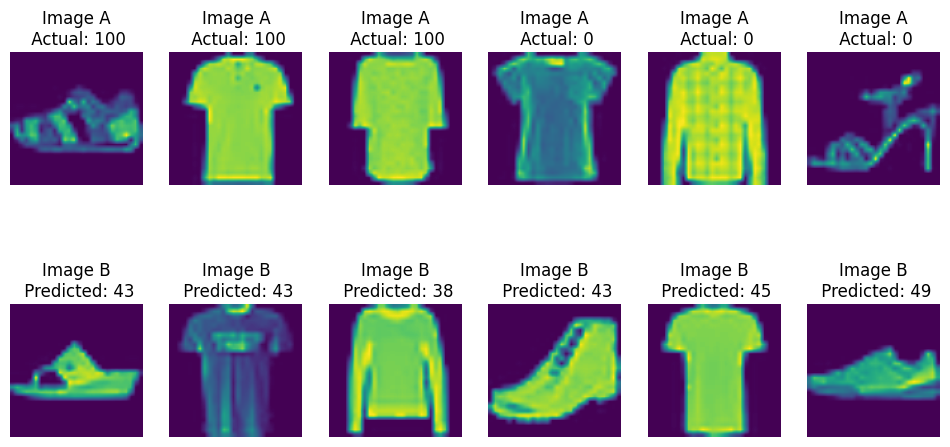

In [ ]:
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

In [ ]:
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = False)

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 24ms/step


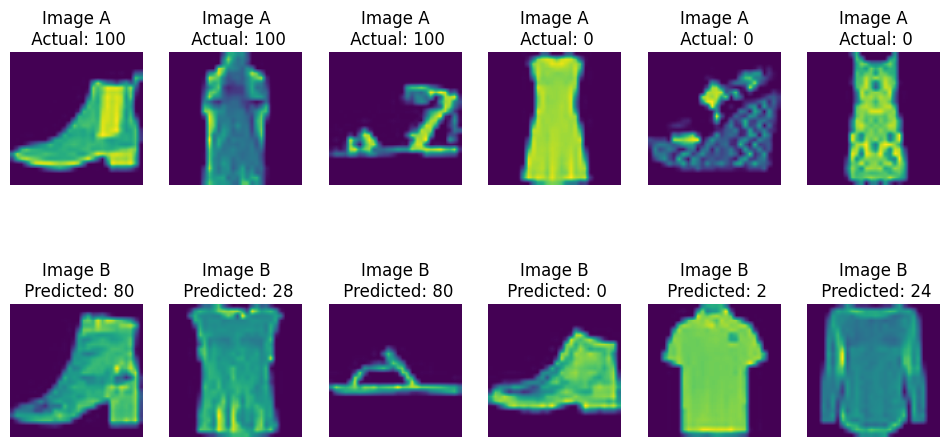

In [ ]:
_ = show_model_output()

In [ ]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

79/79 [==============================] - 3s 36ms/step


In [ ]:
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
    )
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.025s...
[t-SNE] Computed neighbors for 10000 samples in 0.714s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.615s
[t-SNE] Iteration 50: error = 77.6469193, gradient norm = 0.0180679 (50 iterations in 3.612s)
[t-SNE] It

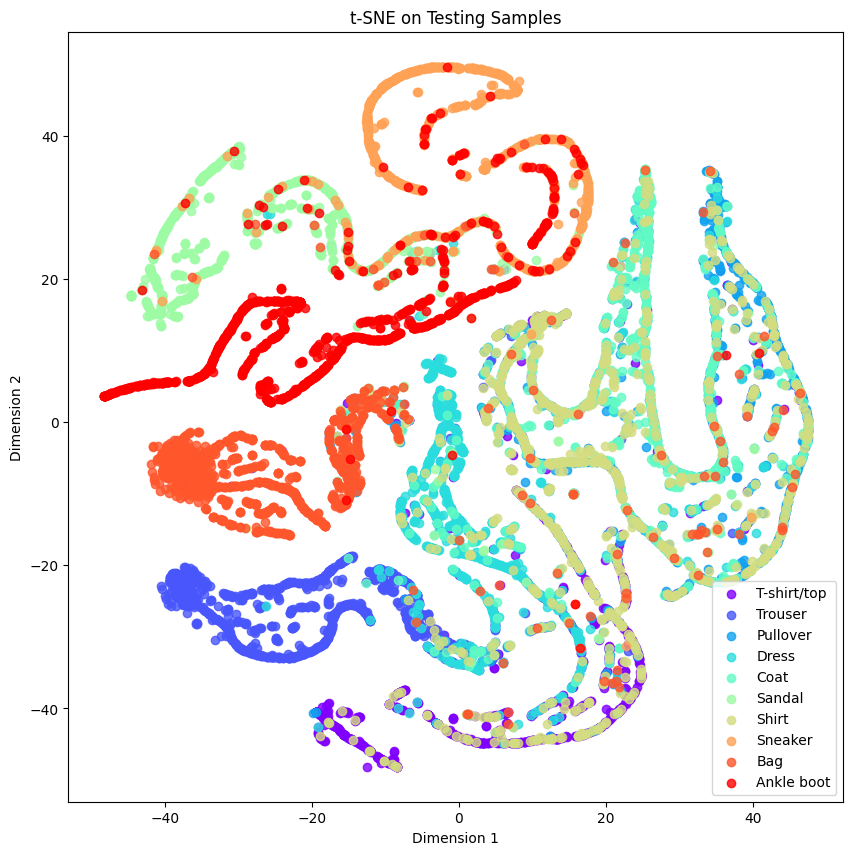

In [ ]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)